In [237]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from matplotlib.patches import Rectangle

(1)

Reduction notes on 5150_HW
                                
2009 June 22 local (23rd UT)

Observer: Kobulnicky, J. Runnoe, J. Dornfeld

Clearish, 55F, Humidity 56%

Winds 020 @ 10 mph

d01-d15 Darks

a093-a111 Bias

-Overscan looks like 0-52 and 2102-2199 based on np.argwhere

-Chip suggests clip 60-2094 in x and 5 to 2044 in y for safety with edge pixels

-Average bias/overscan levels of 665 ADU

-Removed H-alpha images 005-020, 091-092,127-129,176-178 and "bad image" 63

In [ ]:
#My rewrite of IRAF method IMCOMBINE in Python-3
#Takes multiple images, lets work from text file instead of data
#Can do avg, med and sig clipping based on passed params
def imcombine(infile,average=False,median=False,sig=False,signum=3):
    #text file opener
    files=open(infile)
    #combined data(for avg) and an intialize boolean
    cmb_data=[]; init=False; cnt=0
    
    
    for i in files:
        cnt += 1 #increment counter
        hdul = fits.open(('Imaging/'+str.strip(i)))
        data = hdul[0].data
        #Scales to 1 (moving outside fn)
        #data=data/np.average(data) 
        
        cmb_data.append(data)
       
    #determine row and col length of images
    y=len(cmb_data[0])
    x=len(cmb_data[0][0])
    cmb_data=np.asarray(cmb_data)
    
    temp=cmb_data
    #If sig filter is true
    out_data=[]
    if(sig):
        for i in range(cnt):
            avg=np.average(cmb_data[i])
            std=np.std(cmb_data[i])
            
            #If value > avg+-3sig set equal to image average.
            cmb_data[i][cmb_data[i] > avg+signum*std] = avg
            cmb_data[i][cmb_data[i] < avg-signum*std] = avg
    
            
    #If average is true, overrides median if both are true
    if(average):
        avg=cmb_data[0]
        for i in cmb_data[1:]:
            avg+=i
        avg=avg/cnt
        return(avg)
    
    #If median is true
    #much much faster, one line vectored median from Matt Messersmith on S/O
    #https://stackoverflow.com/questions/52990299/faster-median-in-very-large-numpy-arrays
    if(median):
        median = np.zeros((1,y,x))
        median[0, :, :] = np.median(cmb_data,axis=0)

        return(median[0])        

In [239]:
#Rewrite of IRAF method colbias in Python 3
#Overscan looks like 0-52 and 2102-2199
#Chip suggests clip 60-2094 in x and 5 to 2044 in y
def colbias(data,plot):
    #Remove Overscan
    data_cp=[]
    bias_avg=[]
    for i in range(len(data)):
        #Calculate bias
        bias=np.average(data[i][2102:2199])
        bias_avg.append(bias)

        #remove bias and clip images
        if(i>4 and i<2044):
            data_cp.append(data[i][60:2094]-bias)
    #rewrite into np_array
    data_cb=np.asarray(data_cp)
    #Plot bias vals
    if(plot):
        plt.figure()
        plt.plot(bias_avg)
        plt.show()
    #Return output array
    return data_cb

In [240]:
#Rewrite of IRAF method imstat in Python 3
def imstat(data,x1=0,x2=100000,y1=0,y2=100000):
    #If x2,y2 not set, set them to the max of the passed data
    if(x2==100000):
        x2=len(data[0])
        y2=len(data)
    #print(x1,x2,y1,y2)
    #clipped data, if applicable
    data_cp=[]
    #clip data to given range
    for i in range(len(data)):
        #clip in y
        if(i>y1 and i<y2):
                #clip in x
                data_cp.append(data[i][x1:x2])
    #Thank you numpy
    return([np.average(data_cp),np.std(data_cp),np.max(data_cp),np.min(data_cp)])

(3) Assess the RMS and mean levels of an image
Use IRAF/IMPLOT to practice plotting lines and columns of data from one of the bias
images. Use the ’s’ key to compute the mean and the RMS of several rows and several columns
and record these measurements.

Now use the IMSTAT task to compute the mean and RMS of a region near the center of
the chip. To address a subregion of an image, use ’imstat file.fits[x1:x2,y1:y2]’
Finally, use IDL or Python to read in a bias image, plot several rows and columns, and
use STDDEV or a similar function to compute the RMS of 1) a couple rows and columns,
and 2) the same square subregion near the center of the image you used for IMSTAT.

Choosing Bias image a100 arbitrarily
Lets start by plotting and calling imstat on the full image:

[665.5540234045388, 8.940528052483735, 1998, 586]


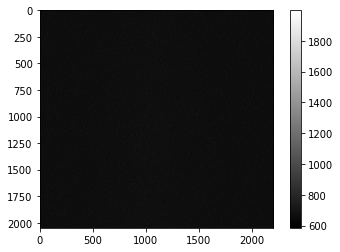

In [241]:
hdul = fits.open(('Imaging/a100.fits'))
#hdul.info()
data = hdul[0].data
print(imstat(data))
plt.figure()
plt.imshow(data, cmap='gray')
plt.colorbar()
plt.show()

So from the Imstat we can see that the average pixel level is around 665, which is consistent
with other biases I examined manually. And the actual photo region seems consistent with
the overscan region, which is good for a bias. We do see that the max count is 1998, so there
may be a cosmic ray or some other high pixel effect for some unknown reason.

We can now call imstat on a couple defined regions of the image, I'll take a couple 200x200 
pixel chunks and examine those. Note that my imstat method takes a x and y range just like IRAF


	Average		St-Dev		Max	Min
[662.6251507537688, 8.760378803814282, 720, 592]
[666.5480653266332, 8.494168929611517, 726, 599]
[664.1257035175879, 8.41910979147691, 716, 599]
[667.6546733668341, 8.630610229497783, 729, 601]
[664.7336683417085, 8.423893519071573, 720, 599]
[670.748391959799, 8.72115834862806, 731, 604]


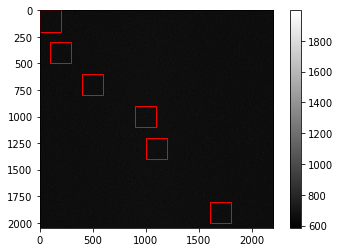

In [242]:
print("\tAverage\t\tSt-Dev\t\tMax\tMin")
print(imstat(data,0,200,0,200))
print(imstat(data,600,800,600,800))
print(imstat(data,1800,2000,1800,2000))
print(imstat(data,1200,1400,1200,1400))
print(imstat(data,300,500,1100,1300))
#Near the center
print(imstat(data,1000,1200,1000,1200))

#This figure shows the six selected regions I called imstat on overlayed on the image.
plt.figure()
plt.imshow(data, cmap='gray')
plt.gca().add_patch(Rectangle((0,0),200,200,linewidth=1,edgecolor='r',facecolor='none'))
plt.gca().add_patch(Rectangle((400,600),200,200,linewidth=1,edgecolor='r',facecolor='none'))
plt.gca().add_patch(Rectangle((1600,1800),200,200,linewidth=1,edgecolor='r',facecolor='none'))
plt.gca().add_patch(Rectangle((1000,1200),200,200,linewidth=1,edgecolor='r',facecolor='none'))
plt.gca().add_patch(Rectangle((100,300),200,200,linewidth=1,edgecolor='r',facecolor='none'))
plt.gca().add_patch(Rectangle((900,900),200,200,linewidth=1,edgecolor='r',facecolor='none'))
plt.colorbar()
plt.show()

(5) Examine the all bias exposures (or overscan regions throughout the night) using a task like
IMSTAT and quantify how much the bias level changes throughout the night. Compare the
mean level of the biases to the mean levels of the overscan regions from other files throughout
the night. How much variation do you find? 

Make an argument for whether it would be a good or bad idea to combine all of the biases to make a master bias and subtract that from all the images versus using the overscan region of each image as an estimate of the bias level.

Lets start by reading in all the bias images 93-111 and calling imstat:

In [243]:
biases=open('Imaging/biases.txt')
print('Filename\tavg\t\tst-dev\t\tmax\tmin')
for i in biases:
    hdul = fits.open(('Imaging/'+str.strip(i)))
    #hdul.info()
    data = hdul[0].data
    print(str.strip(i),imstat(data))

Filename	avg		st-dev		max	min
a093.fits [665.8359934715992, 9.532312054872786, 7536, 572]
a094.fits [665.5070102589154, 8.903502240863862, 1338, 586]
a095.fits [665.5606366301017, 8.925521797394907, 1653, 587]
a096.fits [665.6745385708575, 8.916827068703576, 1473, 579]
a097.fits [665.6627563618599, 9.15277768684181, 3757, 589]
a098.fits [665.6400330861127, 8.911355751032593, 1268, 587]
a099.fits [665.5938435404361, 8.908459576221627, 1499, 567]
a100.fits [665.5540234045388, 8.940528052483735, 1998, 586]
a101.fits [665.5795634409557, 8.906792946655987, 1190, 586]
a102.fits [665.5473069236576, 9.059260050520631, 2945, 571]
a103.fits [665.5647992627793, 9.203966394771657, 3266, 586]
a104.fits [665.554126659857, 8.900575082606613, 1118, 570]
a105.fits [665.5509610516499, 8.898568039557365, 1131, 580]
a106.fits [665.5912850290891, 9.238827284923303, 3395, 586]
a107.fits [665.541141137807, 8.98011777977131, 2480, 587]
a108.fits [665.6051043655905, 8.958506557219433, 1984, 589]
a109.fits [665

So the bias level is pretty dang consistent at around 665, next lets read in some random images
(every 20th or so) and call imstat on their larger overscan region (pixels 2102-2199):
I checked that these images were indicated as suitable in the log file

In [244]:
img=['a022','a042','a062','a082','a112','a132','a153','a173','a192','a212','a240']
print('Filename\tavg\t\tst-dev\t\tmax\tmin')
for i in img:
    hdul = fits.open(('Imaging/'+i+'.fits'))
    #hdul.info()
    data = hdul[0].data
    print(i,'.fits',imstat(data,x1=2102,x2=2199))

Filename	avg		st-dev		max	min
a022 .fits [676.5751640570309, 19.0333346928995, 887, 598]
a042 .fits [671.7257288765555, 13.368014561609666, 807, 589]
a062 .fits [673.5703342583313, 10.428515695895323, 781, 597]
a082 .fits [663.1242250414234, 8.349876349997666, 720, 587]
a112 .fits [663.1754088205521, 8.667594235639825, 721, 587]
a132 .fits [660.5225650814116, 8.356303163071527, 718, 594]
a153 .fits [660.0244713158305, 8.00837099430875, 718, 590]
a173 .fits [661.7305234212502, 8.29505465513221, 717, 590]
a192 .fits [665.1025287194234, 8.401095824551035, 724, 592]
a212 .fits [665.7915783218086, 8.430818192003025, 726, 592]
a240 .fits [678.5817515196994, 8.437184919519401, 738, 609]



From these results we see that the bias level in the overscan regions starts ~10 ADU higher than
the actual bias image values and then decreases for a while, eventually increasing back towards the inital values. This suggests to me that we could probably get a pretty good master bias image as the values from the actual biases are close to being in the center of the values of the overscans throughout the night.

However, I don't actually think this would be better than using the overscan region and would add unnessacarry additional noise. So I think simply using the overscan region to remove the bias from each science image would be best.



(6) Using IRAF/CCDPROC or COLBIAS fit and subtract the overscan region of each image and
trim the image to remove the overscan region. In the overscan fitting, use interactive fitting
and try out ’chebychev’, ’legandre’, and ’spline3’ of various orders for the fitting function.
Qualitatively try to summarize the differences between the functions, and for extra credit,
look up in some math textbook and summarize the properties of these types of polynomials.
Also try orders 1 through about 8, and make an argument for how large an order is necessary
to fit the overscan region. Turn in a plot of your fit to one of the overscan regions. To make
hardcopy in IRAF use ’=’ or use ’set stdplot=eps’ to make a hardcopy postscript file.



As I wrote my own colbias file, it simply calculates an average of the overscan rows and 
subtracts that from each row, clipping the images aswell. As an example I'll first use 
image a022 to show the effect of colbias and then apply the effect to all images

The first plot and imstat print out is before colbias is applied
the second plot and imstat is after colbias is applied


[23058.575520051516, 6113.603493226084, 65535, 588]


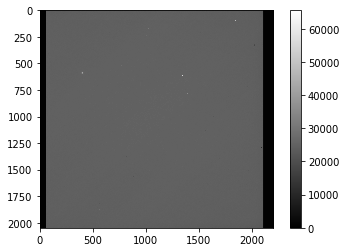

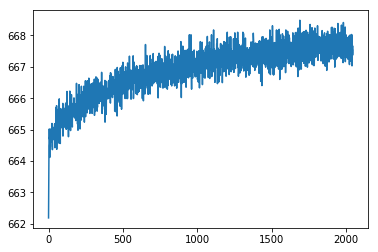

[24062.75159956897, 444.711822081008, 64868.886597938144, 22.773195876288696]


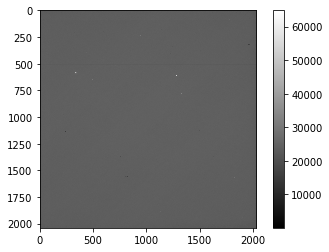

In [245]:
hdul = fits.open(('Imaging/a046.fits'))

data = hdul[0].data
print(imstat(data))
plt.figure()
plt.imshow(data, cmap='gray')
plt.colorbar()
plt.show()

data_cb=colbias(data,True)
print(imstat(data_cb))
plt.figure()
plt.imshow(data_cb, cmap='gray')
plt.colorbar()
plt.show()

In comparing the two plots we can see the that the overscan region has clearly been trimmed off the image, also from the imstat data we can see that the standard deviation of values in the image has been massively reduced by applying colbias.

The middle plot which is of the colbias values and shows that the bias level starts right around 665 as we would expect from previous results, and then increases by ~3 ADU as the chip is read out.


(7) Combine the bias frames into a master bias frame using IMCOMBINE in IRAF. By visual
inspection or using image statistics, decide whether it is appropriate to combine all your bias
exposures to make 1 master bias, or whether you need to restrict the input frames because of
variations among your bias frames. Are there trends in your sequence of bias frames? Does
either the level, or the pattern of the bias change throughout the night? If so, by how much
(ADU and in electrons)? How much noise would you be adding to your data if you decide to
do a bias subtraction in addition to your overscan subtraction. Do the subtraction of your
master bias from all other science frames if you can justify that it is warranted.


As we have previously examined the bias images in question 5 and saw that they all have very
similar averages and standard deviations I feel comfortable combining them into a master 
bias. (The bias averages change by less than 0.5 ADU or ~1.5 electrons over the exposures)


In [246]:
#Lets start by using imcombine to take the average and doing 3-sigma rejection
avg_bias=imcombine('Imaging/biases.txt',average=True,sig=True)
print(imstat(avg_bias))

#Lets also try with median and 3-sigma rejection

med_bias=imcombine('Imaging/biases.txt',median=True,sig=True)
print(imstat(med_bias))

[665.8159398863543, 2.81524652532484, 678.6842105263158, 648.3157894736842]
[665.730989918728, 2.702117365526861, 679.0, 640.0]


From these results we see that imcombine taking either the average or the median provides a master bias image with avg~=665 and standard deviation ~=3 ADU.

If we did a master bias subtraction in addition to the overscan subtraction I suspect we would add ~sqrt(665.7)=25.801 ADU of noise to each pixel (Shot noise). I do not feel that this subtraction is necessary as the overscan region seems to provide a better estimate of the bias level at the time of each exposure for the science worthy images.


(8) Now examine the ’dark’ images quantitatively with IMPLOT and estimate the range of dark
current (electrons per pixel per second) you see in the darks. Use either Python or IRAF’s
IMHEAD task to see the exposure time in each of the darks. Pixels will vary! Be careful to
avoid being fooled by cosmic rays, which will appear as large bright spots usually spread over
a few pixels, whereas high dark current is usually isolated to just individual pixels.


In [247]:
#Lets start by opening all of the dark images, taking an imstat and also printing the exposure
#time from the fits header.

darks=open('Imaging/darks.txt')
for i in darks:
    hdul = fits.open(('Imaging/'+str.strip(i)))
    #hdul.info()
    data = hdul[0].data
    print(str.strip(i),', exposure time =',hdul[0].header['EXPTIME'])
    print('\tAvg\t\tSt-Dev\t\tMax\tMin')
    print(imstat(data),'\n')

d001.fits , exposure time = 2
	Avg		St-Dev		Max	Min
[660.6541657414398, 4.929629490498907, 1666, 614] 

d002.fits , exposure time = 2
	Avg		St-Dev		Max	Min
[660.5544548563307, 4.972759519624138, 2510, 613] 

d003.fits , exposure time = 2
	Avg		St-Dev		Max	Min
[660.389474841231, 5.36781630712187, 3461, 615] 

d004.fits , exposure time = 2
	Avg		St-Dev		Max	Min
[660.2730989918728, 4.9303213602008835, 1235, 618] 

d005.fits , exposure time = 2
	Avg		St-Dev		Max	Min
[660.3197679531021, 4.934872762117581, 1524, 611] 

d006.fits , exposure time = 5
	Avg		St-Dev		Max	Min
[659.3682653106541, 5.1276502818304905, 2949, 605] 

d007.fits , exposure time = 5
	Avg		St-Dev		Max	Min
[659.1677461473554, 4.928819709214308, 1801, 615] 

d008.fits , exposure time = 5
	Avg		St-Dev		Max	Min
[658.9806304125772, 5.370542330270576, 4578, 617] 

d009.fits , exposure time = 5
	Avg		St-Dev		Max	Min
[658.8813034596083, 5.09563167205065, 1792, 613] 

d010.fits , exposure time = 5
	Avg		St-Dev		Max	Min
[658.81495137

We see that we have darks of 2,5 and 300 seconds. I am surprised to see that the average number of counts generally seems to decrease in the longer darks, however I do note that the standard deviation increases noticeably with longer darks.

Comparing the standard deviation of the short darks (~5ADU) to the longer darks (~8.6ADU) I would estimate a standard dark current of 3.6 ADU/295 sec = 0.122 ADU/sec per pixel or with a Gain = 3 this gives 0.366 electrons per second per pixel.




(9) Use IMCOMBINE to combine darks together to make a master dark. You will need to play
with different combination parameters to see which one does the best job of eliminating cosmic
rays. At a minimum, do
• A straight average of all dark frames (combine=average)
• A straight median of all dark frames (combine=median)
• An average where outlier pixels are rejected if they are more than 3 sigma from the mean
(reject=sigclip).
• A median where outlier pixels are rejected if they are more than 3 sigma from the mean
(reject=sigclip or avsigclip).
Use the resulting RMS in the master image as an indicator of which combination procedure
is best. Compare your master dark to your master bias to estimate the significance of the
highest dark count pixels...how many times larger is the typical dark current than the noise
(σ) in the master dark image?

In [248]:
#We can begin by calculating our master dark under all four suggest imcombines and taking imstat
print('\t\t\tAvg\t\t\tSt-Dev\t\tMax\tMin')

avg_dark=imcombine('Imaging/darks.txt',average=True,median=False,sig=False)
print('Straight Average    :',imstat(avg_dark))

avgsig_dark=imcombine('Imaging/darks.txt',average=True,median=False,sig=True)
print('Average w/ rejection:',imstat(avgsig_dark))

med_dark=imcombine('Imaging/darks.txt',average=False,median=True,sig=False)
print('Straight Median     :',imstat(med_dark))

medsig_dark=imcombine('Imaging/darks.txt',average=False,median=True,sig=True)
print('Median w/ rejection :',imstat(medsig_dark))

			Avg			St-Dev		Max	Min
Straight Average    : [658.6991585468762, 3.074439887943721, 1830.0, 631.2666666666667]
Average w/ rejection: [658.6911594498974, 2.677103049005358, 669.4, 647.8]
Straight Median     : [658.7449205045077, 2.915782979244804, 671.0, 628.0]
Median w/ rejection : [658.7588295510059, 2.780630161857139, 671.0, 647.0]


From these results we can see that the methods with sigma rejection clearly give a lower standard deviation in the resulting master image and the average w/ rejection gives the best standard deviation result.

From earlier we saw that the master bias had an imstat result:
[665.8159398863543, 2.81524652532484, 678.6842105263158, 648.3157894736842]

where as the master dark has the result:
[658.6911594498974, 2.677103049005358, 669.4, 647.8]

From these we can see that the effect of the dark current is extremely small as the st-dev of the dark is in fact smaller than the st-dev of the master bias.